In [34]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
import time

### Create Array of Nuclear Masses From Data Files

I need an array of nuclear rest masses `nuclear_mass[Z, N]`. These masses come from databases with some combination of experimental measurements and nuclear model predictions.

"mass16-reduced.txt" is a reduced data table from the 2016 Atomic Mass Evaluation (AME). Its columns contain: neutron number, proton number, atomic mass in amu.

"frdm12.dat" (received from Hendrik Schatz) contains mass excesses from the FRDM2012 mass model. Its columns contain: proton number, mass number (nucleon number), and mass excess in MeV/c^2.

For my calculations I need nuclear rest masses (not atomic masses). So I need to convert the mass excesses into atomic masses and subtract the electron rest mass. I ignore the electron binding energies because they are negligible (on the order of eV where the total mass is on the order of MeV).

In [2]:
# Data from 'mass16-reduced.txt' and 'frdm12.dat'.
# 'mass16-reduced.txt' contains experimental data from the 2016 Atomic Mass Evaluation.
# 'frdm12.dat' contains mass estimates from the FRDM2012 mass model.

# Load AME data.
neutron_number_ame, proton_number_ame, atomic_mass_ame = np.loadtxt('mass16-reduced.txt', unpack=True)
# Convert proton and nucleon numbers to integers so they can be used as indices.
proton_number_ame, neutron_number_ame = proton_number_ame.astype(int), neutron_number_ame.astype(int)

# Atomic mass unit in units of MeV/c^2
amu = 931.49410242
# Electron mass in units of MeV/c^2
electron_mass = 5.48579909070e-4*amu

# Convert atomic masses from amu to MeV/c^2 and convert to nuclear masses by subtracting electron rest mass.
nuclear_mass_ame = atomic_mass_ame*amu - proton_number_ame*electron_mass

# Load FRDM data
proton_number_frdm, nucleon_number_frdm, mass_excess_frdm = np.loadtxt('frdm12.dat', unpack=True)
# Convert proton and nucleon numbers to integers so they can be used as indices.
proton_number_frdm, nucleon_number_frdm = proton_number_frdm.astype(int), nucleon_number_frdm.astype(int)
# Calculate neutron number.
neutron_number_frdm = nucleon_number_frdm - proton_number_frdm

# Nuclear masses from FRDM data.
nuclear_mass_frdm = mass_excess_frdm + nucleon_number_frdm*amu - proton_number_frdm*electron_mass

# Create 2D array of masses with axes of Z and N
# We will take experimental (AME) values where possible. Otherwise will use model (FRDM) values.

# Determine overall dimensions of array based on the largest values of Z and N in both datasets.
Z_max = np.max([np.max(proton_number_ame), np.max(proton_number_frdm)])
N_max = np.max([np.max(neutron_number_ame), np.max(neutron_number_frdm)])

# We don't have data for all nuclides in the ZxN space, so we initialize values with NaN and will fill in the values for which we have data.
nuclear_mass = np.full((int(np.max(Z_max)) + 1, int(np.max(N_max)) + 1), np.NaN)

# First load model masses then experimental masses. Experimental values will overwrite model values where they exist.
# Iterate through each nuclide, determine Z and N values for that nuclide, then store its nuclear mass in the appropriate space in the ZxN array.

# FRDM model masses
for i, Z in enumerate(proton_number_frdm):
    N = neutron_number_frdm[i]
    
    nuclear_mass[Z, N] = nuclear_mass_frdm[i]
    
# AME experimental masses
for i, Z in enumerate(proton_number_ame):
    N = neutron_number_ame[i]
    
    nuclear_mass[Z, N] = nuclear_mass_ame[i]

In [22]:
print(np.max(neutron_number_frdm))

236


### Calculation of Density from Pressure

In the outer crust of a neutron star we assume there is an ion lattice with a background of uniform, relativistic, degenerate electrons. We also assume the ion lattice is of one nuclide species and that the system is charge-neutral.

Due to changes in the ground state composition throughout the crust, there may be discontinuities in density. However, pressure will be continuous which makes it a more useful quantity to treat as the independent variable for probing the properties of the crust at different depths. Typically the pressure is expressed and calculated as a function of density and composition, so we must use a root finding method to determine the density for a given composition and pressure.

I will summarize the calculation here, but a more detailed explanation and derivation of the calculation is in Chamel_Haensel_2008.

The electron energy density is

$\epsilon_e = \dfrac{m_e^4 c^5}{8 \pi^2 \hbar^3} \bigg(x_r (2 x_r^2 + 1) \sqrt{x_r^2 + 1} - \log{\big(x_r + \sqrt{x_r^2 + 1}\big)}\bigg)$

where $m_e$ is the mass of the electron and $x_r$ is the dimensionless relativity parameter:

$x_r = \dfrac{\hbar(3 \pi^2 n_e)^{1/3}}{m_e c}$

where $n_e$ is the density of electrons.

Assuming point-like nuclei, the lattice energy density is:

$\epsilon_L = -\dfrac{9}{10} \bigg(\dfrac{4 \pi}{3}\bigg)^{1/3} Z^{2/3} e^2 n_e^{4/3}$

where $Z$ is the charge number of the ions in the lattice and $e$ is the elementary charge.

These forms of the equations may be inconvenient if using nuclear units (MeV and fm) rather than cgs or mks. They can be reformulated in terms of $m_e c^2$, $\hbar c$, and the fine structure constant $\alpha = e^2/\hbar c$.

$\epsilon_e = \dfrac{(m_e c^2)^4}{8 \pi^2 (\hbar c)^3} \bigg(x_r (2 x_r^2 + 1) \sqrt{x_r^2 + 1} - \log{\big(x_r + \sqrt{x_r^2 + 1}\big)}\bigg)$

$x_r = \dfrac{\hbar c (3 \pi^2 n_e)^{1/3}}{m_e c^2}$

$\epsilon_L = -\dfrac{9}{10} \bigg(\dfrac{4 \pi}{3}\bigg)^{1/3} Z^{2/3} \alpha \hbar c n_e^{4/3}$

The total pressure can be expressed as

$P_{tot} = P_e + \frac{1}{3} \epsilon_L$

where $P_e$ is the electron pressure:

$P_e = -\epsilon_e + \mu_e n_e$

with an electron chemical potential of $\mu_e$. The electron chemical potential is

$\mu_e = m_e c^2 \sqrt{1 + x_r^2}$

To determine the density at a given pressure, we find the root of the function $P_e(n_e) + \frac{1}{3} \epsilon_e(n_e) - P_{tot}$. Assuming charge neutrality and a given composition with charge number $Z$ and mass number $A$, we can calculate the baryon density from $n_b = \frac{A}{Z} n_e$.

In [3]:
def pressure_to_baryon_density(electron_density, P_tot, Z, N, units='cgs'):
    '''
    Calculates the pressure of an ion lattice given a density of background 
    electrons. 
    
    Assumes the system to be charge-neutral and that the electrons form a
    uniform, degenerate gas.
    '''
    
    pi = np.pi
    
    # Set constants according to assigned unit system
    if units == 'cgs':
        m_e = 9.1093837015e-28
        c = 2.99792458e10
        m_ec2 = m_e*c**2
        h_bar = 1.054571817e-27
        h_barc = h_bar*c
        alpha = 0.0072973525693
    
    elif units == 'nuclear':
        m_ec2 = 0.5110
        h_bar = 6.582e-22
        h_barc = 197.3
        alpha = 0.0072973525693
    
    # Electron relativity parameter (unitless)
    x_r = h_barc*(3*pi**2*electron_density)**(1/3)/m_ec2

    # Electron energy density (MeV/fm^3)
    electron_energy_density = m_ec2**4/(8*pi**2*h_barc**3)*(x_r*(2*x_r**2 + 1)*np.sqrt(x_r**2 + 1) - np.log(x_r + np.sqrt(x_r**2 + 1)))

    # Electron chemical potential (MeV)
    mu_e = m_ec2*np.sqrt(1 + x_r**2)

    # Lattice energy density (MeV/fm^3)
    lattice_energy_density = -.9*(4*pi/3)**(1/3)*Z**(2/3)*alpha*h_barc*electron_density**(4/3)

    # Electron pressure (cgs: erg/cm^3; nuclear: MeV/fm^3)
    P_e = -electron_energy_density + mu_e*electron_density
    
    return P_e + 1/3*lattice_energy_density - P_tot

## Calculate Gibbs Free Energy and Stability

Due to degeneracy, we can treat the system as having temperature $T = 0$. Since we are fixing the pressure, the Gibbs free energy per nucleon is the thermodynamic free energy of interest: $g(P) = (\epsilon_{tot} + P)/n_b$.

We can find the ground state composition of a single-species lattice of ions by minimizing the Gibbs free energy per nucleon at a given pressure as a function of charge number $Z$ and neutron number $N$: $g(Z, N; P)$.

### Test at Single Pressure

Here I calculate the Gibbs free energy per nucleon for each nuclide at a single given pressure. I use the root finder for each nuclide to determine the electron density and baryon density at that pressure. I then calculate the electron energy density, lattice energy density, total energy density, and Gibbs free energy per nucleon.

I store all thermodynamic quantities in 2D arrays where the index `[Z, N]` corresponds to that quantity for the nuclide with charge number $Z$ and neutron number $N$. For example, the lattice energy density for carbon-12 at the given pressure would be stored as `lattice_energy_density[6, 6]`.

In [30]:
# Solve Gibbs free energy for each nuclide at a given pressure and plot in a heatmap

pi = np.pi
# Conversion factor from MeV to ergs. Multiply this by a value in MeV to get the value in ergs.
MeV_to_erg = 1.60218e-6

units = 'cgs'

# Test at a single total pressure (units of erg/cm^3)
P_tot = 1e28

# Set constants according to assigned unit system
if units == 'cgs':
    m_e = 9.1093837015e-28
    c = 2.99792458e10
    m_ec2 = m_e*c**2
    h_bar = 1.054571817e-27
    h_barc = h_bar*c
    alpha = 0.0072973525693

elif units == 'nuclear':
    m_ec2 = 0.5110
    h_bar = 6.582e-22
    h_barc = 197.3
    alpha = 0.0072973525693

# The maximum values of Z and N included in the chart of nuclides that we use.
Z_max = np.shape(nuclear_mass)[0]
N_max = np.shape(nuclear_mass)[1]

# Create arrays of proton number Z, neutron number N, and nucleon number A.
# Useful to have for array operations.
neutron_number, proton_number = np.meshgrid(np.arange(N_max), np.arange(Z_max))
nucleon_number = proton_number + neutron_number

# Minimum and maximum bounds for baryon density (1/cm^3) to be used for root finding
n_b_min = 1e6/1.66e-24
n_b_max = 1e11/1.66e-24
# Minimum and maximum bounds for electron density to be used for root finding
n_e_min = n_b_min/np.max(nucleon_number)
n_e_max = n_b_max

# Arrays of densities for each nuclide at the given pressure
baryon_density = np.full_like(nuclear_mass, np.NaN)
electron_density = np.full_like(nuclear_mass, np.NaN)

# Loop through all nuclides to solve for the baryon density at the given pressure.
for Z in range(Z_max):
    for N in range(N_max):
        
        # If the value for the nuclear mass is NaN, then we have no data and so we skip this nuclide.
        # If the nuclide contains no protons, it cannot form a lattice and exist as a species in the outer crust.
        if np.isnan(nuclear_mass[Z, N]) or Z == 0:
            continue
        
        else:
            # Calculate baryon density using root finding method
            electron_density[Z, N] = optimize.root_scalar(pressure_to_baryon_density, args=(P_tot, Z, N), method='brentq', bracket=[n_e_min, n_e_max]).root
                        
baryon_density = nucleon_number/proton_number*electron_density

# Electron relativity parameter (unitless)
relativity_parameter = h_barc*(3*pi**2*electron_density)**(1/3)/m_ec2

# Electron energy density (erg/cm^3)
electron_energy_density = m_ec2**4/(8*pi**2*h_barc**3)*(relativity_parameter*(2*relativity_parameter**2 + 1)*np.sqrt(relativity_parameter**2 + 1) \
                            - np.log(relativity_parameter + np.sqrt(relativity_parameter**2 + 1)))

# Electron chemical potential (erg)
electron_chemical_potential = m_ec2*np.sqrt(1 + relativity_parameter**2)

# Electron pressure (erg/cm^3)
electron_pressure = -electron_energy_density + electron_chemical_potential*electron_density

# Lattice energy density (erg/cm^3)
lattice_energy_density = -.9*(4*pi/3)**(1/3)*proton_number**(2/3)*alpha*h_barc*electron_density**(4/3)

# Total pressure (erg/cm^3)
total_pressure = electron_pressure + lattice_energy_density/3

# Total energy density in erg/cm^3
total_energy_density = baryon_density/nucleon_number*nuclear_mass*MeV_to_erg + electron_energy_density + lattice_energy_density

# Total mass density in g/cm^3
mass_density = total_energy_density/c**2

# Gibbs free energy per baryon in MeV
gibbs_free_energy = ((total_energy_density + P_tot)/baryon_density)/MeV_to_erg

/tmp/ipykernel_11458/2727280225.py:60: RuntimeWarning: divide by zero encountered in true_divide
  baryon_density = nucleon_number/proton_number*electron_density
/tmp/ipykernel_11458/2727280225.py:60: RuntimeWarning: invalid value encountered in true_divide
  baryon_density = nucleon_number/proton_number*electron_density


### Determine Beta-Stability for Each Nuclide

Here I determine the beta-stability of each nuclide based on two conditions:

1. Stable against electron capture if $g(Z, N) < g(Z-1, N+1)$
2. Stable against beta decay if $g(Z, N) < g(Z+1, N-1)$

For a nuclide to be stable, both conditions must be true. If the $(Z-1, N+1)$ or $(Z+1, N-1)$ nuclide has no nuclear data, then I assume that it is less stable than the $(Z, N)$ nuclide and the corresponding stability condition is automatically true.

I store the stability condition for each nuclide in an array where nuclides that are unstable have a value of 0 and nuclides that are stable have a value of 1. Nuclides for which we have no nuclear data have a value of `NaN`.

I then plot the Gibbs free energy per nucleon with stable nuclides marked in black.

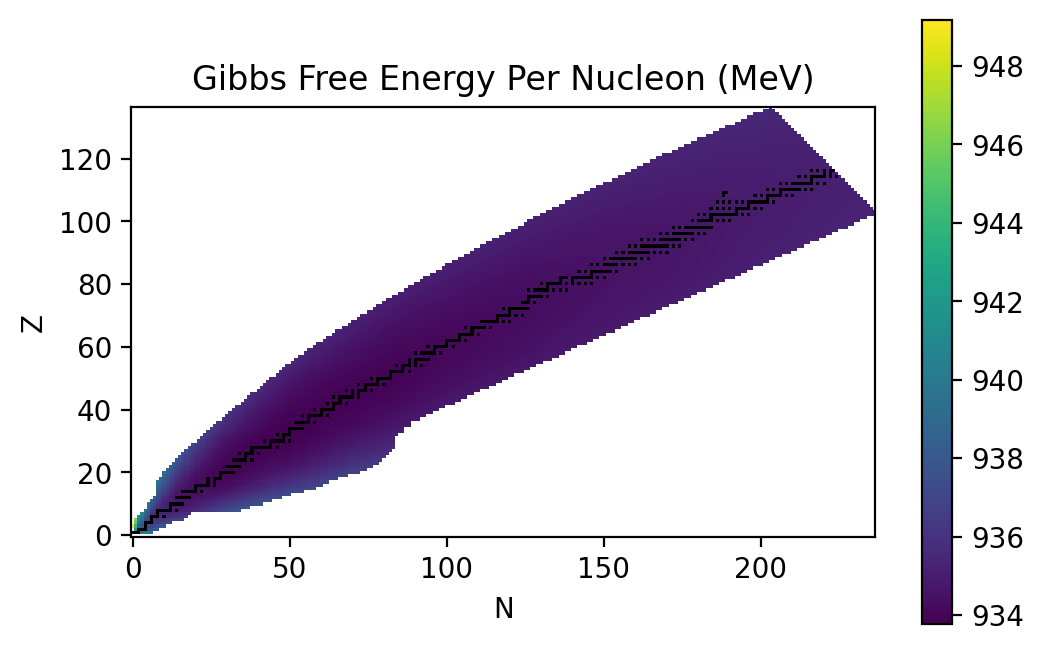

In [31]:
# Determine beta stability of each nuclide at the pressure from the previous cell
# Beta stability is determined by two factors: stability against electron capture, and stability against beta decay (electron emission)

# Arrays for each stability condition
# Values are nan for nuclides that are unstable and will be 1 for nuclides that are stable.
electron_capture_stable = np.full_like(gibbs_free_energy, np.NaN)
electron_emission_stable = np.full_like(gibbs_free_energy, np.NaN)

for Z in range(gibbs_free_energy.shape[0]):
    for N in range(gibbs_free_energy.shape[1]):
        
        # If the value for the atomic mass is NaN, then we have no data and so we skip this nuclide.
        if np.isnan(gibbs_free_energy[Z, N]):
            continue
            
        # Test for stability against electron capture.
        # If the current nuclide's Gibbs free energy is less than that of the product of electron capture, then it is stable.
        # If the product of electron capture has no data, we assume it is less stable than the current nuclide.
        try:
            if np.isnan(gibbs_free_energy[Z-1, N+1]) or gibbs_free_energy[Z, N] < gibbs_free_energy[Z-1, N+1]:
                electron_capture_stable[Z, N] = 1
        except:
            continue
        
        # Test for stability against electron emission.
        # If the current nuclide's Gibbs free energy is less than that of the product of electron emission, then it is stable.
        # If the product of electron emission has no data, we assume it is less stable than the current nuclide.
        try:
            if np.isnan(gibbs_free_energy[Z+1, N-1]) or gibbs_free_energy[Z, N] < gibbs_free_energy[Z+1, N-1]:
                electron_emission_stable[Z, N] = 1
        except:
            continue
            
# Overall beta stability is determined by stability to both stability conditions.
beta_stable = electron_capture_stable*electron_emission_stable

# Plot the Gibbs free energy per nucleon of each nuclide
# Highlight nuclides that are beta stable
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(200)

plot = plt.imshow(gibbs_free_energy, origin='lower')
plt.imshow(beta_stable, cmap='gray', origin='lower')
fig.colorbar(plot)
plt.title('Gibbs Free Energy Per Nucleon (MeV)')
plt.xlabel('N')
plt.ylabel('Z')
plt.show()

In [37]:
# Determine absolute ground state

# Maximum values of Z and N in the chart of nuclides
Z_max = gibbs_free_energy.shape[0]
N_max = gibbs_free_energy.shape[1]

# The absolute ground state is the nuclide with the overall minimum value of Gibbs free energy.
ground_index = np.nanargmin(gibbs_free_energy)

# nanargmin unwraps the 2D array, so to we need to determine which 2D indices the result corresponds to.
Z_ground = ground_index//N_max
N_ground = ground_index%N_max

print(Z_ground, N_ground)
print(gibbs_free_energy[Z_ground, N_ground])
print(nuclear_mass[Z_ground, N_ground]/(Z_ground + N_ground))
print(mass_density[Z_ground, N_ground])

32 50
933.7758510875785
930.4969433628487
12730273198.668404


In [38]:
print(electron_energy_density[26, 30])
print(electron_pressure[26, 30])
print(lattice_energy_density[26, 30])
print(total_energy_density[26, 30])

3.146620063501325e+28
1.041861359155259e+28
-1.255840774657813e+27
9.573630309394768e+30


### Gibbs Free Energy and Stability Functions

Here I put the above calculations and stability determination into functional form for easier use. I then test the functions to confirm they yield the same results as the above calculations.

In [39]:
def gibbs_free_energy_per_nucleon(P_tot, nuclear_mass, n_b_min = 1e6/1.66e-24, n_b_max = 1e12/1.66e-24):
    pi = np.pi
    MeV_to_erg = 1.60218e-6

    units = 'cgs'

    # Set constants according to assigned unit system
    if units == 'cgs':
        m_e = 9.1093837015e-28
        c = 2.99792458e10
        m_ec2 = m_e*c**2
        h_bar = 1.054571817e-27
        h_barc = h_bar*c
        alpha = 0.0072973525693

    elif units == 'nuclear':
        m_ec2 = 0.5110
        h_bar = 6.582e-22
        h_barc = 197.3
        alpha = 0.0072973525693

    Z_max = np.shape(nuclear_mass)[0]
    N_max = np.shape(nuclear_mass)[1]

    # Create arrays of proton number Z, neutron number N, and nucleon number A.
    # Useful to have for array operations.
    neutron_number, proton_number = np.meshgrid(np.arange(N_max), np.arange(Z_max))
    nucleon_number = proton_number + neutron_number

    # Minimum and maximum bounds for electron density to be used for root finding
    n_e_min = n_b_min/np.max(nucleon_number)
    n_e_max = n_b_max

    # Array of densities for each nuclide at the given pressure
    baryon_density = np.full_like(nuclear_mass, np.NaN)

    electron_density = np.full_like(nuclear_mass, np.NaN)

    # Loop through all nuclides to solve for the baryon density at the given pressure.
    for Z in range(Z_max):
        for N in range(N_max):

            # If the value for the nuclear mass is NaN, then we have no data and so we skip this nuclide.
            # If the nuclide contains no protons, it cannot form a lattice and exist as a species in the outer crust.
            if np.isnan(nuclear_mass[Z, N]) or Z == 0:
                continue

            else:
                # Calculate baryon density using root finding method
                electron_density[Z, N] = optimize.root_scalar(pressure_to_baryon_density, args=(P_tot, Z, N), method='brentq', bracket=[n_e_min, n_e_max]).root

    # Electron density calculated from Z and A. Determined by charge neutrality
    #electron_density = baryon_density*proton_number/nucleon_number

    baryon_density = nucleon_number/proton_number*electron_density

    # Electron relativity parameter (unitless)
    relativity_parameter = h_barc*(3*pi**2*electron_density)**(1/3)/m_ec2

    # Electron energy density (erg/cm^3)
    electron_energy_density = m_ec2**4/(8*pi**2*h_barc**3)*(relativity_parameter*(2*relativity_parameter**2 + 1)*np.sqrt(relativity_parameter**2 + 1) \
                                - np.log(relativity_parameter + np.sqrt(relativity_parameter**2 + 1)))

    # Electron chemical potential (erg)
    electron_chemical_potential = m_ec2*np.sqrt(1 + relativity_parameter**2)

    # Electron pressure (erg/cm^3)
    electron_pressure = -electron_energy_density + electron_chemical_potential*electron_density

    # Lattice energy density (erg/cm^3)
    lattice_energy_density = -.9*(4*pi/3)**(1/3)*Z**(2/3)*alpha*h_barc*electron_density**(4/3)

    # Total pressure (erg/cm^3)
    total_pressure = electron_pressure + lattice_energy_density/3

    # Total energy density in erg/cm^3
    total_energy_density = baryon_density/nucleon_number*nuclear_mass*MeV_to_erg + electron_energy_density + lattice_energy_density

    # Total mass density in g/cm^3
    mass_density = total_energy_density/c**2

    # Gibbs free energy per baryon in MeV
    gibbs_free_energy = ((total_energy_density + P_tot)/baryon_density)/MeV_to_erg
    
    return mass_density, gibbs_free_energy

In [40]:
def beta_stability(gibbs_free_energy):
    # Determine beta stability of each nuclide at the pressure from the previous cell
    # Beta stability is determined by two factors: stability against electron capture, and stability against beta decay (electron emission)

    # Arrays for each stability condition
    # Values are nan for nuclides that are unstable and will be 1 for nuclides that are stable.
    electron_capture_stable = np.full_like(gibbs_free_energy, np.NaN)
    electron_emission_stable = np.full_like(gibbs_free_energy, np.NaN)

    for Z in range(gibbs_free_energy.shape[0]):
        for N in range(gibbs_free_energy.shape[1]):

            # If the value for the atomic mass is NaN, then we have no data and so we skip this nuclide.
            if np.isnan(gibbs_free_energy[Z, N]):
                continue

            # Test for stability against electron capture.
            # If the current nuclide's Gibbs free energy is less than that of the product of electron capture, then it is stable.
            # If the product of electron capture has no data, we assume it is less stable than the current nuclide.
            try:
                if np.isnan(gibbs_free_energy[Z-1, N+1]) or gibbs_free_energy[Z, N] < gibbs_free_energy[Z-1, N+1]:
                    electron_capture_stable[Z, N] = 1
            except:
                continue

            # Test for stability against electron emission.
            # If the current nuclide's Gibbs free energy is less than that of the product of electron emission, then it is stable.
            # If the product of electron emission has no data, we assume it is less stable than the current nuclide.
            try:
                if np.isnan(gibbs_free_energy[Z+1, N-1]) or gibbs_free_energy[Z, N] < gibbs_free_energy[Z+1, N-1]:
                    electron_emission_stable[Z, N] = 1
            except:
                continue

    '''# Overall beta stability is determined by stability to both stability conditions.
    beta_stable = electron_capture_stable*electron_emission_stable'''
    
    return electron_capture_stable, electron_emission_stable

In [41]:
def neutron_stability(gibbs_free_energy):
    # Determine neutron stability of each nuclide at the pressure from the previous cell
    # Neutron stability is determined by two factors: stability against electron capture, and stability against beta decay (electron emission)

    # Arrays for each stability condition
    # Values are nan for nuclides that are unstable and will be 1 for nuclides that are stable.
    neutron_capture_stable = np.full_like(gibbs_free_energy, np.NaN)
    neutron_emission_stable = np.full_like(gibbs_free_energy, np.NaN)

    for Z in range(gibbs_free_energy.shape[0]):
        for N in range(gibbs_free_energy.shape[1]):

            # If the value for the atomic mass is NaN, then we have no data and so we skip this nuclide.
            if np.isnan(gibbs_free_energy[Z, N]):
                continue

            # Test for stability against neutron capture.
            # If the current nuclide's Gibbs free energy is less than that of the product of neutron capture, then it is stable.
            # If the product of neutron capture has no data, we assume it is less stable than the current nuclide.
            try:
                if np.isnan(gibbs_free_energy[Z, N+1]) or gibbs_free_energy[Z, N] < gibbs_free_energy[Z, N+1]:
                    neutron_capture_stable[Z, N] = 1
            except:
                continue

            # Test for stability against neutron emission.
            # If the current nuclide's Gibbs free energy is less than that of the product of neutron emission, then it is stable.
            # If the product of neutron emission has no data, we assume it is less stable than the current nuclide.
            try:
                if np.isnan(gibbs_free_energy[Z, N-1]) or gibbs_free_energy[Z, N] < gibbs_free_energy[Z, N-1]:
                    neutron_emission_stable[Z, N] = 1
            except:
                continue

    # Overall beta stability is determined by stability to both stability conditions.
    beta_stable = electron_capture_stable*electron_emission_stable
    
    return neutron_capture_stable, neutron_emission_stable

In [42]:
# Test at a single total pressure (units of erg/cm^3)
P_tot = 1e22

mass_density, gibbs_free_energy = gibbs_free_energy_per_nucleon(P_tot, nuclear_mass)
electron_capture_stable, electron_emission_stable = beta_stability(gibbs_free_energy)
neutron_capture_stable, neutron_emission_stable = neutron_stability(gibbs_free_energy)

proton_number = np.zeros(gibbs_free_energy.shape, dtype=int)
neutron_number = np.zeros(gibbs_free_energy.shape, dtype=int)
mass_number = np.zeros(gibbs_free_energy.shape, dtype=int)

for Z in range(gibbs_free_energy.shape[0]):
    for N in range(gibbs_free_energy.shape[1]):
        proton_number[Z, N] = Z
        neutron_number[Z, N] = N
        mass_number[Z, N] = Z + N
        
Z_max = gibbs_free_energy.shape[0]
N_max = gibbs_free_energy.shape[1]

ground_index = np.nanargmin(gibbs_free_energy)

Z_ground = ground_index//N_max
N_ground = ground_index%N_max

print('Ground (Z, N):', Z_ground, N_ground)
print('Mass Density (g/cm^3):', np.format_float_scientific(mass_density[Z_ground, N_ground]))

Ground (Z, N): 26 30
Mass Density (g/cm^3): 6.173435814366185e+05


/tmp/ipykernel_11458/15013213.py:55: RuntimeWarning: divide by zero encountered in true_divide
  baryon_density = nucleon_number/proton_number*electron_density
/tmp/ipykernel_11458/15013213.py:55: RuntimeWarning: invalid value encountered in true_divide
  baryon_density = nucleon_number/proton_number*electron_density


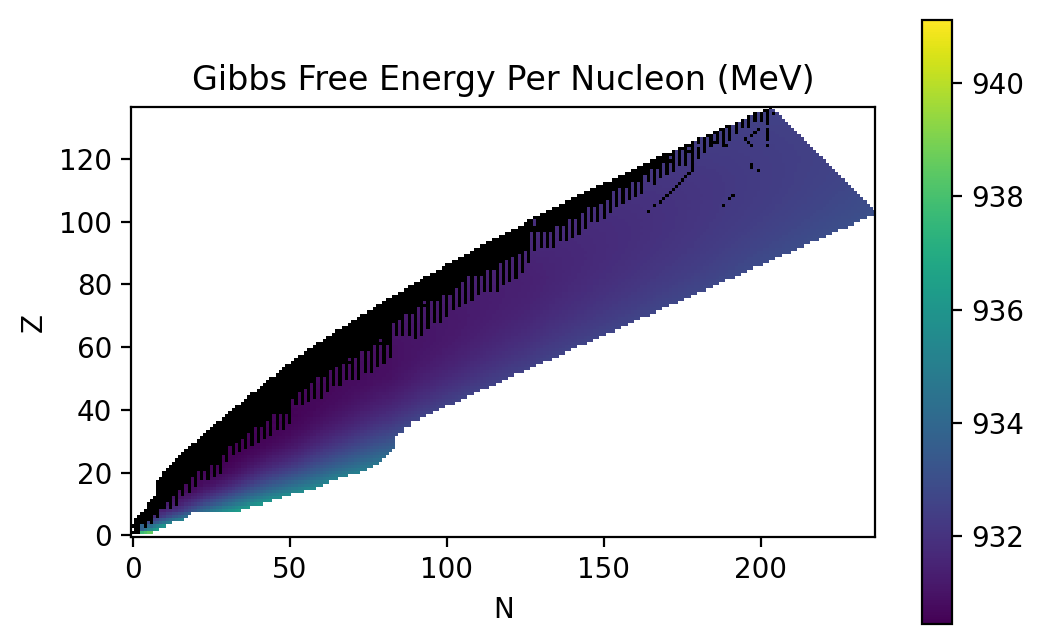

In [43]:
# Plot the Gibbs free energy per nucleon of each nuclide
# Highlight nuclides that are beta stable
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(200)

plot = plt.imshow(gibbs_free_energy, origin='lower')
#plt.imshow(beta_stable, cmap='gray', origin='lower')
plt.imshow(neutron_emission_stable, cmap='gray', origin='lower')
#plt.imshow(neutron_capture_stable*neutron_emission_stable, cmap='gray', origin='lower')
fig.colorbar(plot)
plt.title('Gibbs Free Energy Per Nucleon (MeV)')
plt.xlabel('N')
plt.ylabel('Z')
plt.show()

### Plotting Gibbs Free Energy for Nuclides of Given A

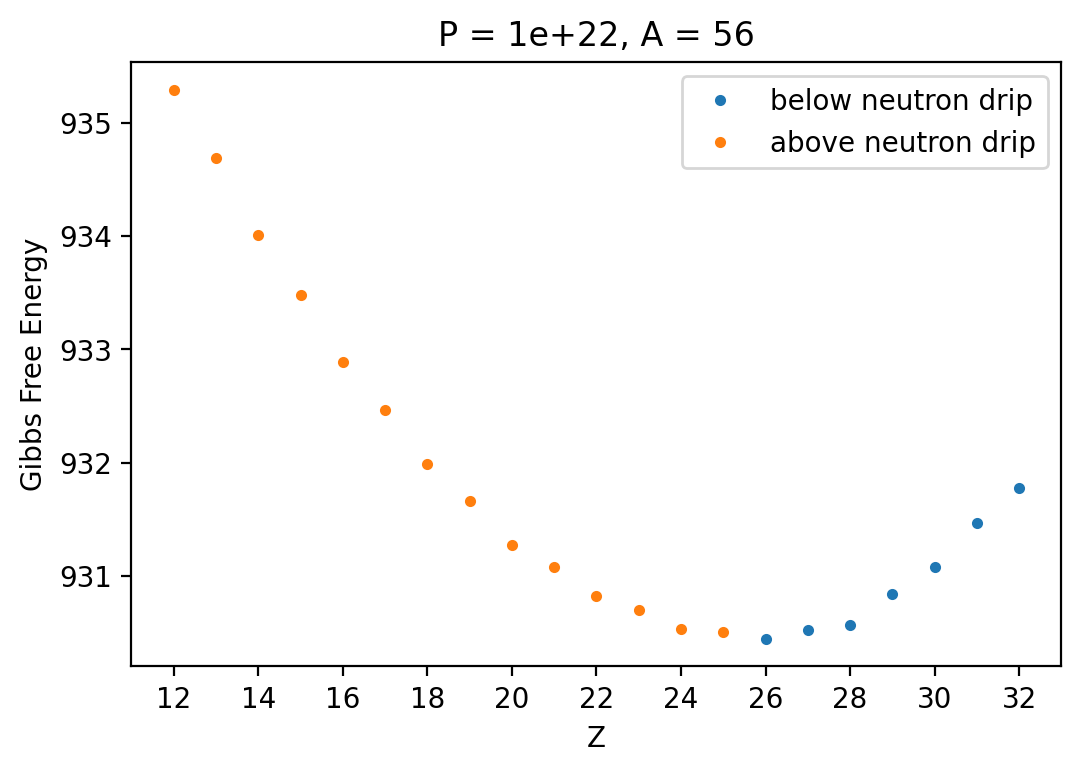

In [44]:
A = 56

mass_mask = (mass_number == A) * (~np.isnan(gibbs_free_energy))

g_constant_A = gibbs_free_energy[mass_mask]
Z_constant_A = proton_number[mass_mask]
below_neutron_drip = neutron_emission_stable[mass_mask] == 1

tick_array = np.arange(Z_constant_A.min(), Z_constant_A.max() + 2, 2)

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(200)

#plt.plot(nuclide_Z, nuclide_gibbs)
plt.plot(Z_constant_A[below_neutron_drip], g_constant_A[below_neutron_drip], '.', label='below neutron drip')
plt.plot(Z_constant_A[~below_neutron_drip], g_constant_A[~below_neutron_drip], '.', label='above neutron drip')
plt.xlabel('Z')
plt.ylabel('Gibbs Free Energy')
plt.title('P = {}, A = {}'.format(P_tot, A))
plt.xticks(tick_array)
plt.legend()
plt.show()

In [67]:
proton_number = np.zeros(nuclear_mass.shape, dtype=int)
neutron_number = np.zeros(nuclear_mass.shape, dtype=int)
mass_number = np.zeros(nuclear_mass.shape, dtype=int)

for Z in range(nuclear_mass.shape[0]):
    for N in range(nuclear_mass.shape[1]):
        proton_number[Z, N] = Z
        neutron_number[Z, N] = N
        mass_number[Z, N] = Z + N
        
num_zones = 14
# Total pressure in erg/cm^3
total_pressure = np.logspace(25, 31, num_zones)

# Arrays to store the values of the mass density and the Z and N values for the ground state nuclide at each pressure.
ground_mass_density = np.zeros_like(total_pressure)
# Each element of the ground_nuclides array is an array of charge number and neutron number [Z, N]
ground_nuclides = np.zeros((len(total_pressure), 2))

all_mass_densities = np.zeros((num_zones, nuclear_mass.shape[0], nuclear_mass.shape[1]))
all_gibbs_free_energies = np.zeros_like(all_mass_densities)
all_electron_capture_stabilities = np.zeros_like(all_mass_densities)
all_electron_emission_stabilities = np.zeros_like(all_mass_densities)
all_neutron_capture_stabilities = np.zeros_like(all_mass_densities)
all_neutron_emission_stabilities = np.zeros_like(all_mass_densities)

A_constant = 56

mass_mask = (mass_number == A_constant) * (~np.isnan(nuclear_mass))

g_constant_A = np.zeros((num_zones, np.sum(mass_mask)))
Z_constant_A = proton_number[mass_mask]
below_neutron_drip = np.zeros((num_zones, np.sum(mass_mask)), dtype=bool)

for i, P_tot in enumerate(total_pressure):
    
    all_mass_densities[i], all_gibbs_free_energies[i] = gibbs_free_energy_per_nucleon(P_tot, nuclear_mass)
    all_electron_capture_stabilities[i], all_electron_emission_stabilities[i] = beta_stability(all_gibbs_free_energies[i])
    all_neutron_capture_stabilities[i], all_neutron_emission_stabilities[i] = neutron_stability(all_gibbs_free_energies[i])
    
    g_constant_A[i] = all_gibbs_free_energies[i][mass_mask]
    below_neutron_drip[i] = all_neutron_emission_stabilities[i][mass_mask] == 1

/tmp/ipykernel_3634/15013213.py:55: RuntimeWarning: divide by zero encountered in true_divide
  baryon_density = nucleon_number/proton_number*electron_density
/tmp/ipykernel_3634/15013213.py:55: RuntimeWarning: invalid value encountered in true_divide
  baryon_density = nucleon_number/proton_number*electron_density


In [68]:
gibbs_min = g_constant_A.min()
gibbs_max = g_constant_A.max()

gibbs_range_min = gibbs_min - .125*(gibbs_max - gibbs_min)
gibbs_range_max = gibbs_max + .125*(gibbs_max - gibbs_min)

tick_array = np.arange(Z_constant_A.min(), Z_constant_A.max() + 2, 2)

'''for i, P_tot in enumerate(total_pressure):
    
    g_min = g_constant_A[i].min()
    g_min_index = np.argmin(g_constant_A[i])
    Z_min = Z_constant_A[g_min_index]
    is_below_neutron_drip = below_neutron_drip[i, g_min_index]
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_dpi(200)

    #plt.plot(nuclide_Z, nuclide_gibbs)
    plt.plot(Z_constant_A[below_neutron_drip[i]], g_constant_A[i][below_neutron_drip[i]], '.', color='tab:blue', label='below neutron drip')
    plt.plot(Z_constant_A[~below_neutron_drip[i]], g_constant_A[i][~below_neutron_drip[i]], '.', color='tab:orange', label='above neutron drip')
    if is_below_neutron_drip:
        plt.plot(Z_min, g_min, 'x', color='tab:blue', label='minimum')
    else:
        plt.plot(Z_min, g_min, 'x', color='tab:orange', label='minimum')
    plt.ylim(gibbs_range_min, gibbs_range_max)
    plt.xlabel('Z')
    plt.ylabel('Gibbs Free Energy')
    plt.title('P = {:.3e}, A = {}'.format(P_tot, A))
    plt.xticks(tick_array)
    plt.legend()
    plt.show()'''

"for i, P_tot in enumerate(total_pressure):\n    \n    g_min = g_constant_A[i].min()\n    g_min_index = np.argmin(g_constant_A[i])\n    Z_min = Z_constant_A[g_min_index]\n    is_below_neutron_drip = below_neutron_drip[i, g_min_index]\n    \n    fig = plt.figure()\n    fig.patch.set_facecolor('white')\n    fig.set_dpi(200)\n\n    #plt.plot(nuclide_Z, nuclide_gibbs)\n    plt.plot(Z_constant_A[below_neutron_drip[i]], g_constant_A[i][below_neutron_drip[i]], '.', color='tab:blue', label='below neutron drip')\n    plt.plot(Z_constant_A[~below_neutron_drip[i]], g_constant_A[i][~below_neutron_drip[i]], '.', color='tab:orange', label='above neutron drip')\n    if is_below_neutron_drip:\n        plt.plot(Z_min, g_min, 'x', color='tab:blue', label='minimum')\n    else:\n        plt.plot(Z_min, g_min, 'x', color='tab:orange', label='minimum')\n    plt.ylim(gibbs_range_min, gibbs_range_max)\n    plt.xlabel('Z')\n    plt.ylabel('Gibbs Free Energy')\n    plt.title('P = {:.3e}, A = {}'.format(P_tot, A

In [69]:
def plot_gibbs(i):
    g_min = g_constant_A[i].min()
    g_min_index = np.argmin(g_constant_A[i])
    Z_min = Z_constant_A[g_min_index]
    is_below_neutron_drip = below_neutron_drip[i, g_min_index]
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_dpi(200)

    #plt.plot(nuclide_Z, nuclide_gibbs)
    plt.plot(Z_constant_A[below_neutron_drip[i]], g_constant_A[i][below_neutron_drip[i]], '.', color='tab:blue', label='below neutron drip')
    plt.plot(Z_constant_A[~below_neutron_drip[i]], g_constant_A[i][~below_neutron_drip[i]], '.', color='tab:orange', label='above neutron drip')
    if is_below_neutron_drip:
        plt.plot(Z_min, g_min, 'x', color='tab:blue', label='minimum')
    else:
        plt.plot(Z_min, g_min, 'x', color='tab:orange', label='minimum')
    plt.ylim(gibbs_range_min, gibbs_range_max)
    plt.xlabel('Z')
    plt.ylabel('Gibbs Free Energy')
    plt.title('P = {:.3e}, A = {}'.format(total_pressure[i], A))
    plt.xticks(tick_array)
    plt.legend(loc='upper left')
    plt.show()

In [70]:
%matplotlib inline
from ipywidgets import interactive

interactive_plot = interactive(plot_gibbs, i=(0, num_zones-1))
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot



interactive(children=(IntSlider(value=6, description='i', max=13), Output()), _dom_classes=('widget-interact',…

### Determining the Absolute Ground State at Different Pressures

Here I perform the Gibbs free energy and stability calculations for a range of pressures in the outer crust. At each pressure I determine the absolute ground state nuclide as well as the mass density. I then plot the mass density as a function of pressure and differentiate between different nuclides to show the variation in composition through the outer crust.

In [10]:
# Total pressure in erg/cm^3
total_pressure = np.logspace(22, 29, 100)

# Arrays to store the values of the mass density and the Z and N values for the ground state nuclide at each pressure.
ground_mass_density = np.zeros_like(total_pressure)
# Each element of the ground_nuclides array is an array of charge number and neutron number [Z, N]
ground_nuclides = np.zeros((len(total_pressure), 2))

start = time.time()

# Iterate through each pressure.
for i, P_tot in enumerate(total_pressure):

    # Calculate the mass density and Gibbs free energy for each nuclide at this pressure.
    mass_density, gibbs_free_energy = gibbs_free_energy_per_nucleon(P_tot, nuclear_mass)
    # Determine beta-stability of each nuclide at this pressure.
    beta_stable = beta_stability(gibbs_free_energy)

    # The maximum values of Z and N in our list of nuclides
    Z_max = gibbs_free_energy.shape[0]
    N_max = gibbs_free_energy.shape[1]

    # The nuclide with the minimum value of Gibbs free energy per nucleon is the absolute ground state.
    # nanargmin gives the index of the absolute ground state of the unwrapped list of nuclides.
    ground_index = np.nanargmin(gibbs_free_energy)

    # Convert the unwrapped index back to the 2D indices.
    Z_ground = ground_index//N_max
    N_ground = ground_index%N_max
    
    # Store the ground state nuclide [Z, N] and the mass density.
    ground_nuclides[i] = np.array([Z_ground, N_ground])
    ground_mass_density[i] = mass_density[Z_ground, N_ground]

end = time.time()

print('Time (s):', end - start)

/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


Time (s): 120.06397652626038


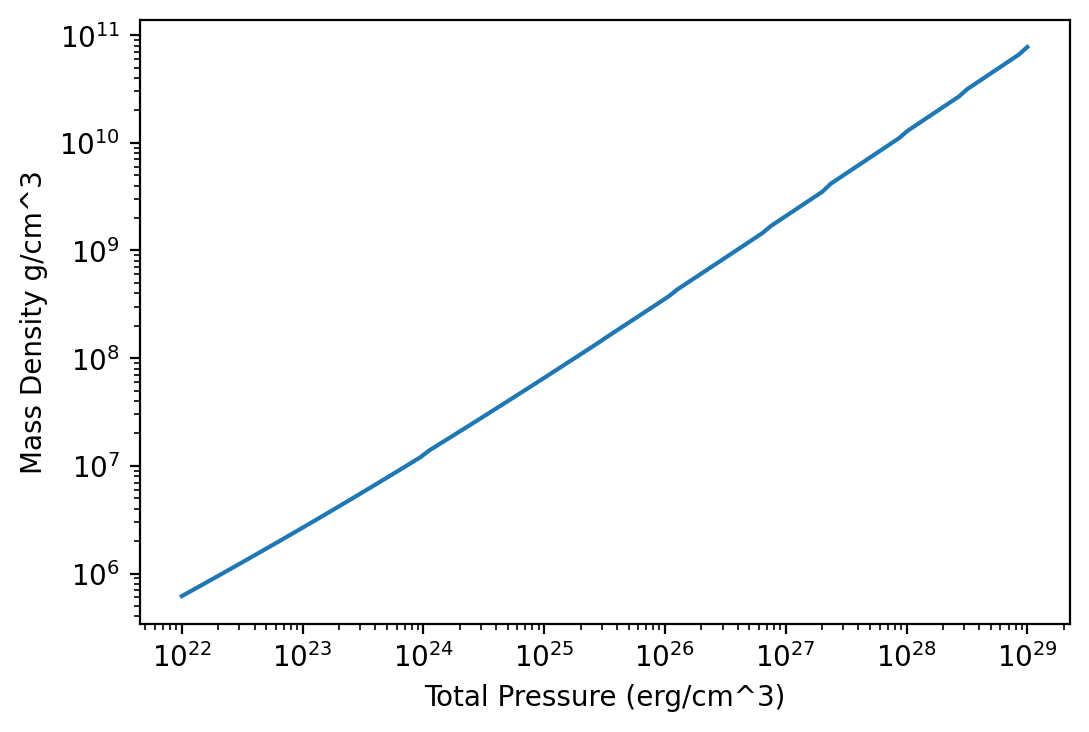

In [28]:
# Plot density as a function of pressure.

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(200)

plt.loglog(total_pressure, ground_mass_density)
plt.xlabel('Total Pressure (erg/cm^3)')
plt.ylabel('Mass Density g/cm^3')
plt.show()

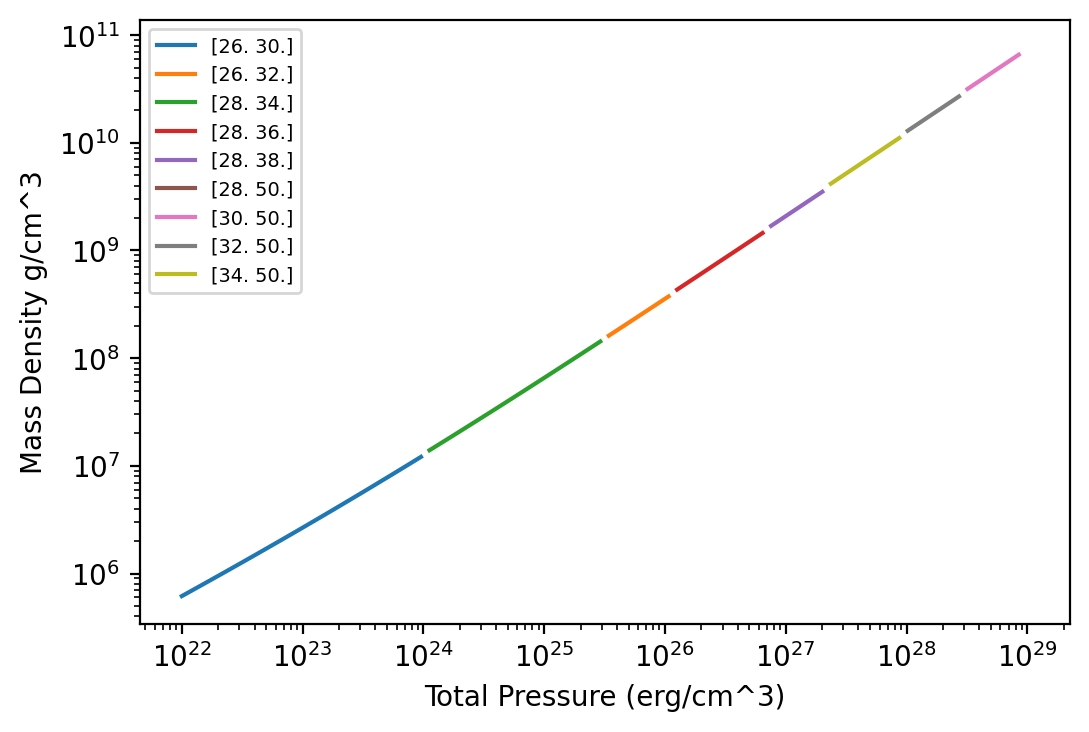

In [29]:
# Plot density as a function of pressure.
# Different ground state nuclides are color-coded to show the change in composition through the outer crust.

# A list of all uniqe nuclides
unique_nuclides = np.unique(ground_nuclides, axis=0)

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(200)

# Plot density vs pressure for each unique nuclide on the same plot.
for unique_nuclide in unique_nuclides:
    # Mask the pressure and density values to include only those that correspond to the current nuclide.
    nuclide_mask = np.all(ground_nuclides == unique_nuclide, axis=1)
    
    plt.loglog(total_pressure[nuclide_mask], ground_mass_density[nuclide_mask], label=unique_nuclide)
    
plt.xlabel('Total Pressure (erg/cm^3)')
plt.ylabel('Mass Density g/cm^3')
plt.legend(fontsize='x-small')
plt.show()

In [26]:
print('Ground Nuclide', 'Mass Density (g/cm^3)', sep='\t')
for unique_nuclide in unique_nuclides:
    nuclide_mask = np.all(ground_nuclides == unique_nuclide, axis=1)

    print(unique_nuclide, np.format_float_scientific(np.min(ground_mass_density[np.all(ground_nuclides == unique_nuclide, axis=1)])), sep='\t')

Ground Nuclide	Mass Density (g/cm^3)
[26. 30.]	6.173435814366183e+05
[26. 32.]	1.6182892550033814e+08
[28. 34.]	1.3961397527590256e+07
[28. 36.]	4.3353015402196914e+08
[28. 38.]	1.6925897732165616e+09
[28. 50.]	7.758031944621245e+10
[30. 50.]	3.1626712344541367e+10
[32. 50.]	1.2951412527924353e+10
[34. 50.]	4.175135303509948e+09
